# 7 AutoGen - GPT-4o

AutoGen is a framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. AutoGen agents are customizable, conversable, and seamlessly allow human participation. They can operate in various modes that employ combinations of LLMs, human inputs, and tools.

17/06/2024

<img src="https://raw.githubusercontent.com/retkowsky/images/master/autogenlogo.jpg">

> Documentation: https://microsoft.github.io/autogen/

In [1]:
import autogen
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import sys

from autogen import Agent, AssistantAgent, ConversableAgent
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.code_utils import content_str
from PIL import Image

In [2]:
sys.version

'3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]'

In [3]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [4]:
check_openai_version()

Installed OpenAI version: 1.30.5
[OK] OpenAI version 1.30.5 is >= 1.0.0


In [5]:
WORK_DIR = "workdir"

os.makedirs(WORK_DIR, exist_ok=True)

## 1. Example 1

In [6]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4o"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": [
            "gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314",
            "gpt-4-32k-v0314"
        ],
    },
)

<img src="https://github.com/retkowsky/images/blob/master/autogen_car_1.jpg?raw=true">

In [7]:
image_agent = MultimodalConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={
        "config_list": config_list_4v,
        "cache_seed": None,
        "temperature": 0.5,
        "max_tokens": 300
    },
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code.
)

# Ask the question with an image
user_proxy.initiate_chat(
    image_agent,
    message="""What is this car?
<img https://github.com/retkowsky/images/blob/master/autogen_car_1.jpg?raw=true>.""",
)

User_proxy (to image-explainer):

What is this car?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The car in the image is a Ferrari Roma. The Ferrari Roma is a grand touring coupe with a sleek and elegant design, featuring a long hood, a fastback roofline, and a modern front grille. It embodies Ferrari's classic styling cues with a contemporary twist.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'What is this car?\n<img https://github.com/retkowsky/images/blob/master/autogen_car_1.jpg?raw=true>.', 'role': 'assistant'}, {'content': "The car in the image is a Ferrari Roma. The Ferrari Roma is a grand touring coupe with a sleek and elegant design, featuring a long hood, a fastback roofline, and a modern front grille. It embodies Ferrari's classic styling cues with a contemporary twist.", 'role': 'user'}], summary="The car in the image is a Ferrari Roma. The Ferrari Roma is a grand touring coupe with a sleek and elegant design, featuring a long hood, a fastback roofline, and a modern front grille. It embodies Ferrari's classic styling cues with a contemporary twist.", cost={'usage_including_cached_inference': {'total_cost': 0, 'gpt-4o-2024-05-13': {'cost': 0, 'prompt_tokens': 373, 'completion_tokens': 54, 'total_tokens': 427}}, 'usage_excluding_cached_inference': {'total_cost': 0, 'gpt-4o-2024-05-13': {'cost': 0, 'prompt_tokens': 

<img src="https://github.com/retkowsky/images/blob/master/autogen_car_2.jpg?raw=true">

In [8]:
# Ask the question with an image
user_proxy.send(
    message="""What is this car?
<img https://github.com/retkowsky/images/blob/master/autogen_car_2.jpg?raw=trueg>

Make a summary of these cars""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

What is this car?
<image>

Make a summary of these cars

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

### Summary of the Cars:

1. **Ferrari Roma**:
   - **Type**: Grand Touring Coupe
   - **Design**: Sleek and elegant with a long hood and fastback roofline.
   - **Features**: Modern front grille, embodying classic Ferrari styling with a contemporary twist.
   - **Performance**: Known for high performance, luxury, and advanced technology.

2. **BMW X2**:
   - **Type**: Subcompact Luxury SUV
   - **Design**: Sporty and dynamic with a coupe-like silhouette.
   - **Features**: Distinctive kidney grille, aggressive front fascia, and modern aesthetics.
   - **Performance**: Combines sporty handling with practicality, featuring advanced tech and luxury amenities.

--------------------------------------------------------------------------------


## 2. Example 2

<img src="https://github.com/retkowsky/images/blob/master/autogen_image_1.jpg?raw=true">

In [9]:
# Ask the question with an image
user_proxy.send(
    message="""Can you describe this image using hashtags and emojis?
<img https://github.com/retkowsky/images/blob/master/autogen_image_1.jpg?raw=true>

Make a summary""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

Can you describe this image using hashtags and emojis?
<image>

Make a summary

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

### Summary:

🌆🌅 #Paris2024 #EiffelTower #Olympics #CityOfLights #Sunset #Paris #France #OlympicGames #IconicLandmark #SeineRiver #Sports #GlobalEvent 🌍🏅

This image captures the iconic Eiffel Tower at sunset, with the Paris 2024 Olympics logo prominently displayed. The serene backdrop of the Seine River and the golden hues of the sunset create a picturesque setting, symbolizing the excitement and grandeur of the upcoming Olympic Games in Paris.

--------------------------------------------------------------------------------


## 3. Example 3

In [10]:
class FigureCreator(ConversableAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: 
        commander, coder, and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)
        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        # Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message="Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip(
            ).endswith("TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": WORK_DIR,
                "use_docker": False,
            },
            llm_config=self.llm_config,
        )

        critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""Criticize the input figure. How to replot the figure so it will be better?
            Find bugs and issues for the figure.
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={
                "config_list": config_list_4v,
                "max_tokens": 300,
                "cache_seed": None
            },
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            # use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "ALWAYS save the figure in 'plot.jpg' file. Tell other agents it is in the <img plot.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open(os.path.join(WORK_DIR, "plot.jpg"))
        plt.imshow(img)
        plt.axis("off")  # Hide the axes
        plt.show()

        for i in range(self._n_iters):
            commander.send(
                message=f"Improve <img {os.path.join(WORK_DIR, 'plot.jpg')}>",
                recipient=critics,
                request_reply=True,
            )

            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to 'final_plot.jpg'\n"
                + feedback,
                recipient=coder,
                request_reply=True,
            )
            img = Image.open(os.path.join(WORK_DIR, "final_plot.jpg"))
            plt.imshow(img)
            plt.axis("off")
            plt.show()

        return True, os.path.join(WORK_DIR, "final_plot.jpg")

In [11]:
gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": None}

In [12]:
csv_url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"

df = pd.read_csv(csv_url)
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [13]:
df.shape

(1461, 6)

In [14]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low in a chart. The high temperature should be orange, 
the low temperature should be blue. All the labels should be visible. 


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low in a chart. The high temperature should be orange, 
the low temperature should be blue. All the labels should be visible. 


--------------------------------------------------------------------------------
Coder (to Commander):

Sure, we will use the pandas, matplotlib, and seaborn libraries in Python to achieve this. Here is the detailed plan:

1. We'll import the required libraries(`pandas` for data handling, 

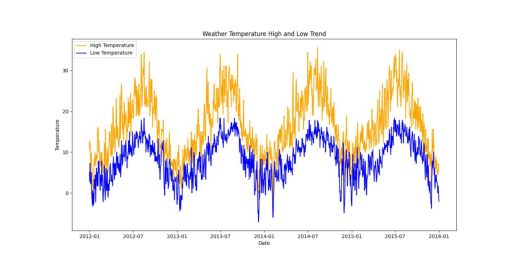

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Critics (to Commander):

To improve the given plot, consider the following suggestions:

### 1. **Title and Labels:**
- **Title:** Make it more descriptive (e.g., "Daily High and Low Temperature Trends from 2012 to 2016").
- **Axes Labels:** The current labels are clear, but they are written in plain text. Consider making them bold for better visibility.

### 2. **Legend:**
- Ensure the legend is not overlapping with the plot data. You can position it outside the plot for a cleaner look (e.g., on the upper right).

### 3. **Gridlines:**
- Add gridlines to the plot to enhance readability. This can help in comparing specific points on the graph more easily.

### 4. **Line Width and Style:**
- Increase the line width slightly for better visibility.
- You can use different line styles (e.g., solid and dashed) to differentiate the plots apart from just using colors. 

#

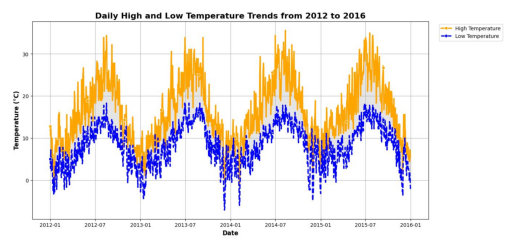

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to 'final_plot.jpg'
Improve <img workdir/plot.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I'm sorry, but your feedback is not specific enough for me to identify which areas of the plot need improvement. Could you please provide more details on which aspects of the plot should be modified? For example, is it the title, labels, legend, gridlines, line width and style, color palette, data markers, shading, or something else that needs change? Please specify so I can assist you better.

--------------------------------------------------------------------------------
Commander (to Coder):

I'm sorry but as an AI, I don't have the capability to run scripts or code directly. To run this script, you need to have Pytho


--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
Commander (to Coder):

exitcode: 0 (execution succeeded)
Code output: 


--------------------------------------------------------------------------------
Coder (to Commander):

It seems that the code was executed successfully, but the output is blank, which implies that the code did not particularly print anything or generate any specific output. 

However, without knowing what the previous code was executing, it's a bit difficult to provide a thorough analysis of what the result signifies. 

If you executed the code for plotting or file generation, kindly check the respective directory for the output file. 

Please provide additional information or a specific question related to this task, if any, for me to provide a more accurate solution or explanation.

TERMINATE

-------------------------------------------------------------------------

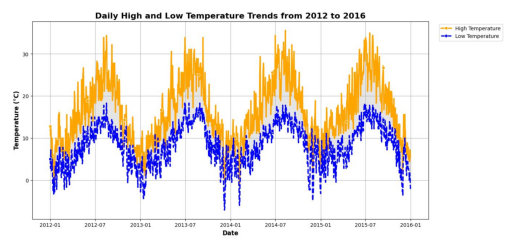

Figure Creator~ (to User):

workdir/final_plot.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '\nPlot a figure by using the data from:\nhttps://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv\n\nI want to show both temperature high and low in a chart. The high temperature should be orange, \nthe low temperature should be blue. All the labels should be visible. \n', 'role': 'assistant'}, {'content': 'workdir/final_plot.jpg', 'role': 'user'}], summary='workdir/final_plot.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [15]:
creator = FigureCreator(name="Figure Creator~", llm_config=gpt4_llm_config)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0,
    code_execution_config={"use_docker": False})

user_proxy.initiate_chat(
    creator,
    message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low in a chart. The high temperature should be orange, 
the low temperature should be blue. All the labels should be visible. 
""",
)

### First plot

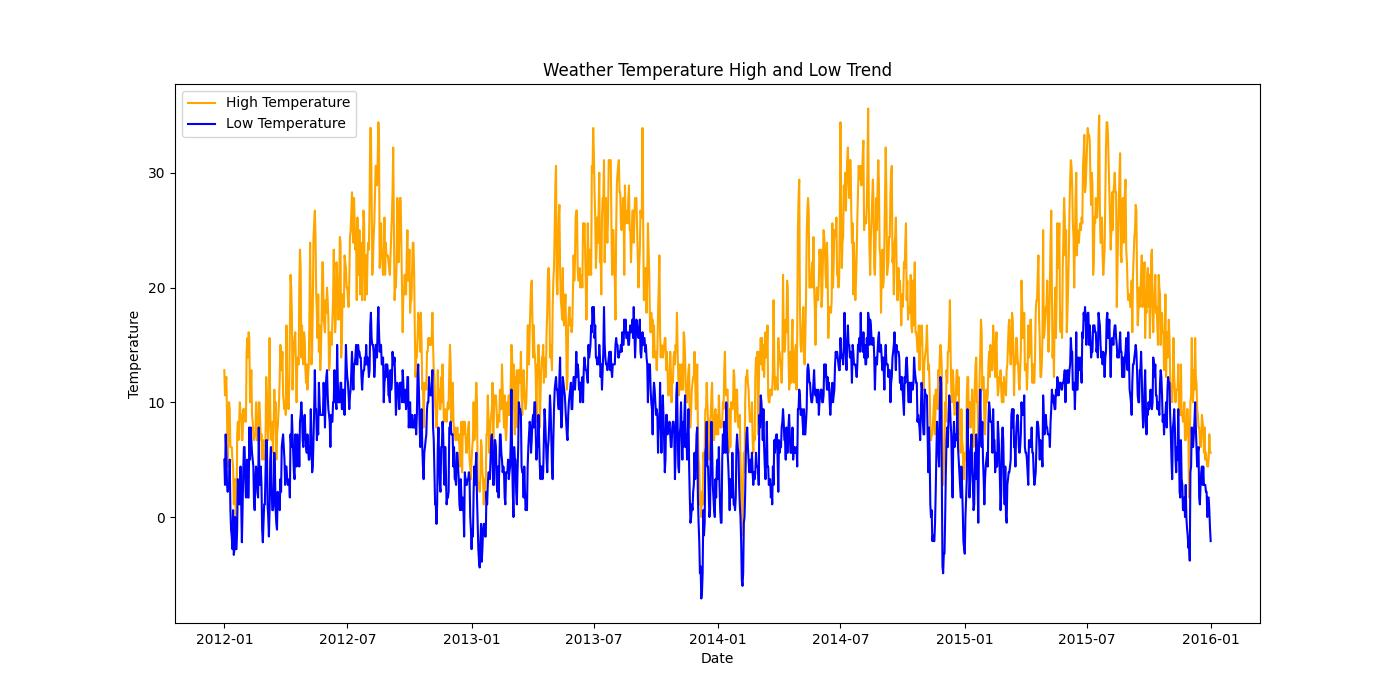

In [16]:
img = Image.open(os.path.join(WORK_DIR, 'plot.jpg'))
img

### Enhanced plot

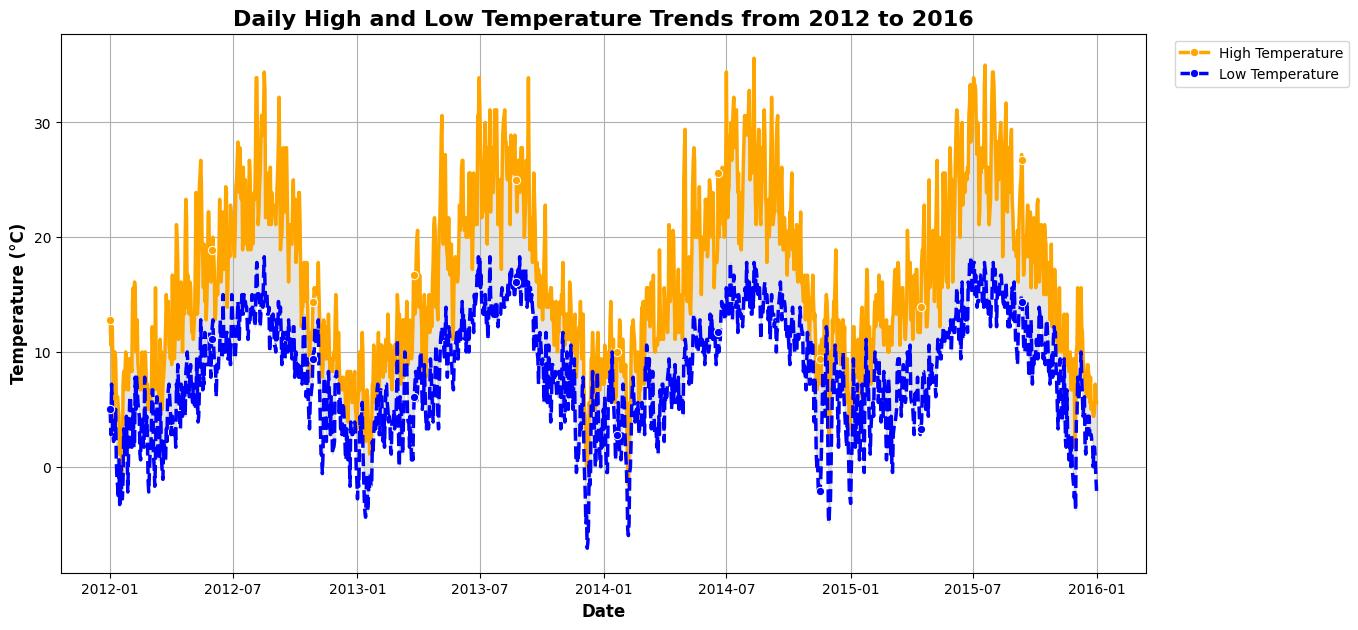

In [17]:
img = Image.open(os.path.join(WORK_DIR, 'final_plot.jpg'))
img

### Both images

In [21]:
def side_by_side_images(imagefile1, imagefile2):
    """
    Side by side images
    """
    # Display images side by side
    image1 = plt.imread(imagefile1)
    image2 = plt.imread(imagefile2)
    # Settings
    f, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(image1)
    ax[1].imshow(image2)
    ax[0].set_title('1. Initial plot')
    ax[1].set_title('2. Enhanced plot')
    #plt.tight_layout()
    plt.show()

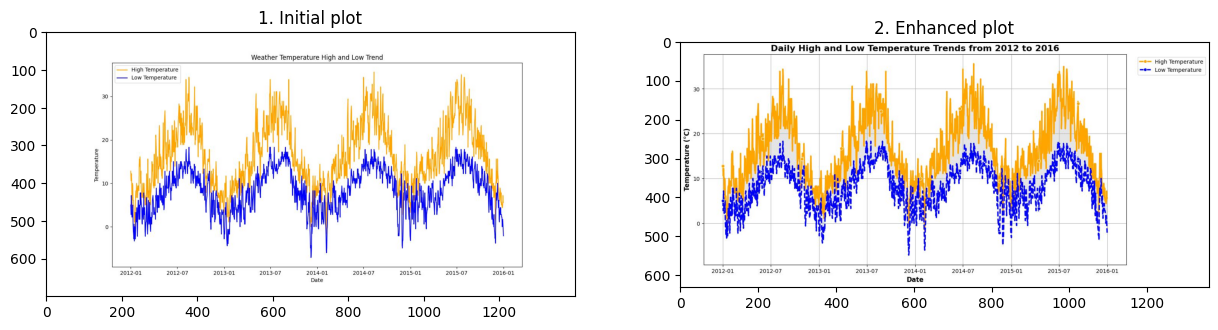

In [22]:
side_by_side_images(
    os.path.join(WORK_DIR, 'plot.jpg'),
    os.path.join(WORK_DIR, 'final_plot.jpg')
)

In [23]:
!ls $WORK_DIR/*.jpg -lh

-rwxrwxrwx 1 root root 120K Jun 17 10:30 workdir/final_plot.jpg
-rwxrwxrwx 1 root root 100K Jun 17 10:29 workdir/plot.jpg
